In [21]:
import numpy as np
import torch
from scipy.io import wavfile
from IPython.display import Audio
import matplotlib.pyplot as plt
import pyroomacoustics as pra
import random
from model import GCC, PGCCPHAT
from scipy.optimize import minimize

# for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [27]:
import numpy as np
import torch
from scipy.io import wavfile
import pyroomacoustics as pra

filename = "F:/speaker localization/44100_final.wav"
fs, signal = wavfile.read(filename)
signal = np.array(signal)

In [28]:
# import pandas as pd
# source_csv = pd.read_csv("F:/speaker localization/label.csv")
# source_arr = source_csv.to_numpy()
# room_dim = [12.0,8.0,5.0]
# t60 = [0.2, 0.4, 0.6, 0.8, 1]
# true_delays = []
# # snr = 10 #db

# Test room parameters
room_dim= [3.0, 2.5, 2.5]
t60 = 0.6 #seconds
snr = 10 # dB

# Microphone locations
mic_locs = np.array([[1.25, 1.0, 1.25], [0.80, 0.90, 1.25], [1.0, 1.25, 1.25]]).T

# Sound source position at the same hight
source_loc = np.array([0.60, 1.20, 1.25])


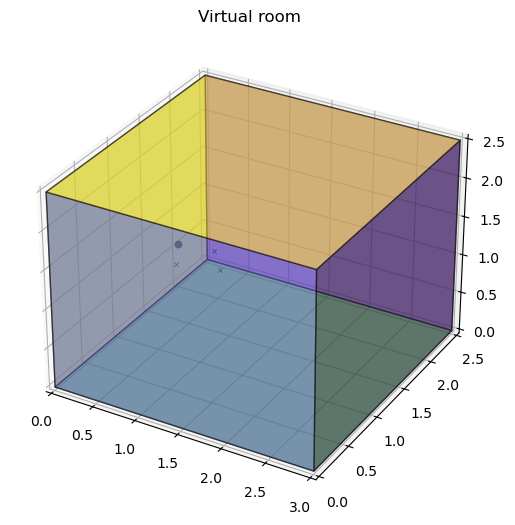

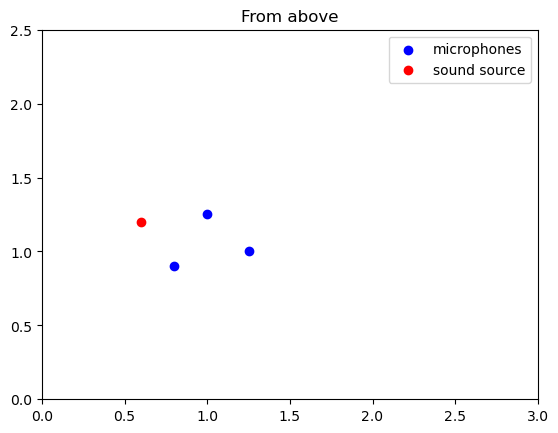

The true TDOAs are [41.080936871619414, 35.60922488852288, -5.471711983096536]


In [29]:
# Test room parameters
room_dim= [3.0, 2.5, 2.5]
t60 = 0.6 #seconds
snr = 10 # dB

# Microphone locations
mic_locs = np.array([[1.25, 1.0, 1.25], [0.80, 0.90, 1.25], [1.0, 1.25, 1.25]]).T

# Sound source position at the same hight
source_loc = np.array([0.60, 1.20, 1.25])

# Create the virtual room
e_absorption, max_order = pra.inverse_sabine(t60, room_dim)

room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(
    e_absorption), max_order=max_order)

c = room.c #speed of sound

room.add_source(source_loc, signal=signal)
room.add_microphone(mic_locs)

fig, ax = room.plot()
ax.set_xlim([0, room_dim[0]])
ax.set_ylim([0, room_dim[1]])
ax.set_zlim([0, room_dim[2]])
plt.title('Virtual room')
plt.show()


fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(mic_locs[0], mic_locs[1], c='b', label='microphones')
ax.scatter(source_loc[0], source_loc[1], c='r', label='sound source')
ax.set_xlim([0, room_dim[0]])
ax.set_ylim([0, room_dim[1]])
plt.title('From above')
plt.legend()
plt.show()

# Calculate the true TDOA 
delays = []
for pairs in [[0, 1], [0, 2], [1, 2]]:
    d = np.sqrt(np.sum((mic_locs[:, pairs[0]] - source_loc)**2)) - np.sqrt(np.sum((mic_locs[:, pairs[1]] - source_loc)**2))
    delays.append(d * fs / c)

print("The true TDOAs are " + str(delays))

(<Figure size 640x480 with 3 Axes>,
 array([[<Axes: title={'center': 'Source 0'}>],
        [<Axes: >],
        [<Axes: xlabel='Time (ms)'>]], dtype=object))

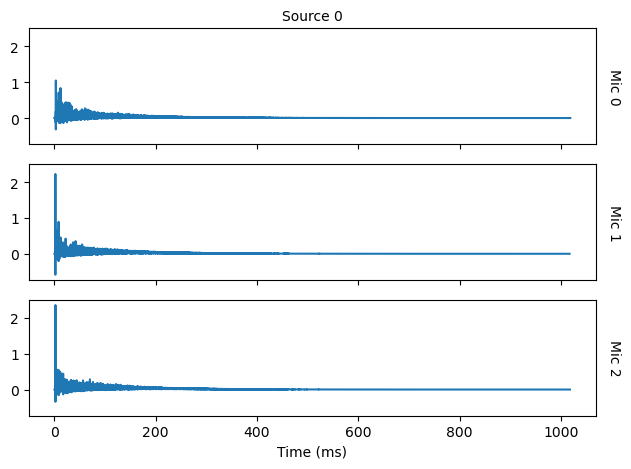

In [30]:
room.plot_rir()

torch.Size([3, 110100])


Text(0.5, 1.0, 'Signal received at mic 0')

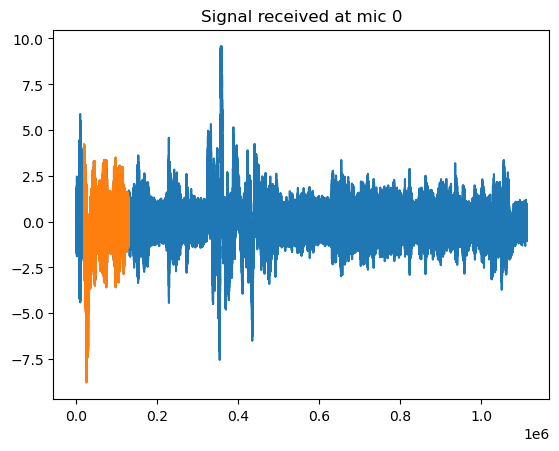

In [36]:
room.simulate(snr=snr)

y = room.mic_array.signals
plt.plot(y[0])

# Pick a 2048 samples long snippet
sig_len = 22050*5
start_idx = 20000
end_idx = start_idx + sig_len

x = torch.Tensor(y[:, start_idx:end_idx])
print(x.shape)
plt.plot(range(start_idx,end_idx), x[0].squeeze())
plt.title("Signal received at mic 0")

In [37]:
max_tau = 23
gcc = GCC(max_tau)
